# PS 88 - Lab 9 - Multivariate Regression

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

## Part 1: Controlling with simulation

To see how controlling for confounding variables can help us estimate causal effects, we will first use some simulated data, and then move on to real data in part 2.

The political science motivation behind the simulations is the relationship between whether protest movements use violence and whether they succeed at attaining their goals. A <a href="http://cup.columbia.edu/book/why-civil-resistance-works/9780231156820">prominent finding</a> in this literature is that nonviolent movements tend to be more likely to achieve their goals. Of course, the choice to use violence is not random, so this may not be a causal effect.

One potential confounding variable is how repressive the government is. In particular, we may  be concerned that violence is more likely to be used when the government is more repressive, and repressive governments are less likely to grant concessions. 

Here is a simulation of this process. There  are three parameters which we will vary later:
- `b_rep` is effect of repression on whether the protest  movement succeeds. We assume this is negative, meaning success is harder with a more repressive government
- `b_viol` is the effect of violence of movement success. For the first simulation, we set this to zero, meaning there is no real causal effect
- `b_rv` is the effect of repressiveness on the use of violence, which we assume is positive

The following code simulates 1000 protest movements, with three variables we will observe: 
- `rep` is the repressiveness, which we will assume is normally distributed
- `viol` is equal to 1 for a violent movement and 0 for nonviolent. We assume movments are more likely to be violent with a repressive government.
- `succ` is a continuous measure of success, where higher numbers indicate a more successful movement. This is (potentially) a function of repressiveness, the choice of violent tactics, and random noise.

We then put the variables in a pandas data frame.

In [95]:
np.random.seed(88)
b_rep = -1
b_viol = 0
b_rv = 1
# Random repressiveness levels
rep = np.random.normal(0,1,1000)
viol = np.where(b_rv*rep + np.random.normal(0,1,1000) > 0, 1, 0)
succ = b_rep*rep + b_viol*viol + np.random.normal(0,.3,1000)
protest = pd.DataFrame(data={'Repressive': rep, 
                             'Violent': viol, 
                             'Success': succ})
protest

,Repressive,Violent,Success
0,0.106884,1,0.129105
1,2.205815,1,-2.308914
2,0.956563,1,-1.272183
3,0.068411,1,0.295149
4,1.068514,1,-1.365457
...,...,...,...
995,0.943206,1,-0.842018
996,-0.852822,1,0.906733
997,0.078483,1,0.208785
998,1.014010,1,-1.212221


Since violence is binary, we can look at the difference in average success between violent and nonviolent movements. Here is some pandas code to compute the average success of violent movements. 

In general, if we want to pull the values of `Var1` for the subset of rows where `Var2=x` from a data frame `df`, the code is:
`df.loc[df['Var2']==x, Var1]`. Think of `.loc` as a combination of what the `.where` and `.column` functions do in the Table library.

In [96]:
suc1 = np.mean(protest.loc[protest['Violent']==1, 'Success'])
suc1

-0.607756432799899

**Question 1.1. Compute the average success of nonviolent movements, and the difference of means between violent and nonviolent movements. What does this mean in words?**

In [97]:
suc0=np.mean(protest.loc[protest['Violent']==0, 'Success'])
suc0

0.5339691689998309

In [98]:
suc1-suc0

-1.14172560179973

In this simulation, violent movements are less successful than violent ones.

While we used regression for continuous variables last week, there is nothing to stop us from using it on binary (0 or 1) variables. Let's run a bivariate regression with `Success` as the dependent variable and `Violent` as the independent variable.

Recall the code to "fit" a model with independent variable IV and dependent variable DV and data frame df is `smf.ols('DV~IV', data=df).fit()`. We will save this fitted model as `succ_ols` and then use the `.summary()` function to get the output.

In [99]:
succ_ols = smf.ols('Success~Violent', data=protest).fit()
succ_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Success   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     430.3
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           9.32e-80
Time:                        10:37:59   Log-Likelihood:                -1276.0
No. Observations:                1000   AIC:                             2556.
Df Residuals:                     998   BIC:                             2566.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5340      0.040     13.227      0.000       0.455       0.613
Violent       -1.1417      0.055    -20.744      0.000      -1.250      -1.034
==============================================================================
Omnibus:                        0.940   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.625   Jarque-Bera (JB):                1.022
Skew:                           0.060   Prob(JB):                        0.600
Kurtosis:                       2.899   Cond. No.                         2.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also visualize this with a scatterplot, where we use the `sns.regplot` function to draw a best fit line too:

<AxesSubplot:xlabel='Violent', ylabel='Success'>

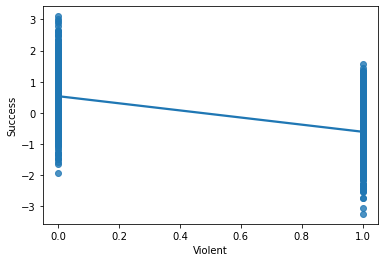

In [100]:
sns.regplot(x='Violent',y='Success', data=protest, ci=0)

The best fit "line" goes from the mean of the nonviolent movements to the mean of the violent movements. Visually:

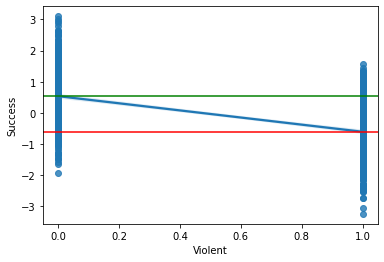

In [101]:
sns.regplot(x='Violent',y='Success', data=protest)
plt.axhline(np.mean(protest.loc[protest['Violent']==1, 'Success']), color="red")
plt.axhline(np.mean(protest.loc[protest['Violent']==0, 'Success']), color="green")

**Question 1.2. What is the relationship between the coefficients from this regression and the average success levels of violent/nonviolent protests?**

The constant in the regression is equal to the mean of nonviolent protests, and the coefficient on `Violent` is the difference of means. 

We can also run regressions with dependent variables that take on values 0 or 1. This is called a "linear probability model". In this example, `Violent` is binary, and by the way we generated the data we know that higher values of `Repressive` make it more likely to be 1 versus 0. 

**Question 1.3. To check this, fit and summarize a regression where `Violent` is the dependent variable and `Repressive` is the independent variable.**

In [102]:
smf.ols('Violent~Repressive', data=protest).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Violent   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     501.4
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           2.64e-90
Time:                        10:39:01   Log-Likelihood:                -519.36
No. Observations:                1000   AIC:                             1043.
Df Residuals:                     998   BIC:                             1053.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5154      0.013     39.904      0.000       0.490       0.541
Repressive     0.2904      0.013     22.392      0.000       0.265       0.316
==============================================================================
Omnibus:                      157.454   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.600
Skew:                          -0.075   Prob(JB):                     6.84e-09
Kurtosis:                       2.062   Cond. No.                         1.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You should get a positive coefficient on `Repressive`, which confirms that we are more likely to have violence when this variable is high. Or, visually:

<AxesSubplot:xlabel='Repressive', ylabel='Violent'>

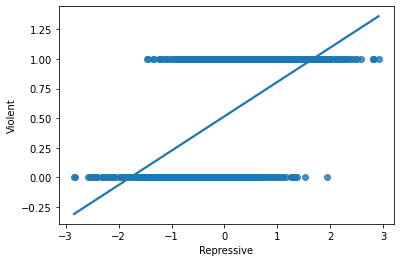

In [103]:
sns.regplot(x='Repressive', y='Violent', data=protest, ci=0)

While our dependent variable really only takes on values of 0 and 1, we can interpret the predicted value here as being a prediction about the probability of violent protest. One drawback to this is that it will sometimes predict negative probabilities or probabilities greater than 1. There are some other ways to analyze data like this that doesn't make predictions outside of 0 and 1, but at the cost of being a bit more complicated to interpret.

The nice thing about this probability interpretation is that the slope then tells us how an increase in our independent variable affects the probability that the dependent variable is a 1. In this case, a 1 unit increase in our `Repressive` measure leads to a 28% increase in the probability of violent protest.

Now let's run a multivaraite regression with `Success` as the dependent variable, and `Violent` and `Repressive` as independent variables.

In [104]:
smf.ols('Success~Violent + Repressive', data=protest).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Success   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     5692.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):               0.00
Time:                        10:39:32   Log-Likelihood:                -195.70
No. Observations:                1000   AIC:                             397.4
Df Residuals:                     997   BIC:                             412.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0112      0.015     -0.743      0.458      -0.041       0.018
Violent        0.0175      0.023      0.764      0.445      -0.027       0.062
Repressive    -1.0065      0.012    -87.488      0.000      -1.029      -0.984
==============================================================================
Omnibus:                        4.394   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                4.387
Skew:                           0.162   Prob(JB):                        0.112
Kurtosis:                       2.990   Cond. No.                         3.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Question 1.4. How did the coefficient on `Violent` change from the bivariate regression (with just `Violent` as the independent variable) to the multivariate regression (with both `Violent` and `Repressive` as independent variables)? Why?**

When we control for how repressive the government is, there is no longer a relationship between violence and protest success. This is because repression was a confounding variable which makes violence more likely and success less likely. So, when we didn't control for repression, it looked like violent movements where less successful. 

Now let's consider a case where there is a causal effect of violence on protest. In particular, let's suppose violence leads to less success. To capture this, we can set `b_viol = -.2` and simulate data using a similar procedure. Note that in this case we explicitly compute the potential outcomes with and without violence, putting these in columns `Success0` and `Success1`.

In [105]:
np.random.seed(99)
b_rep = -1
b_viol = -.2
b_rv = 1
rep = np.random.normal(0,1,1000)
viol = np.where(b_rv*rep + np.random.normal(0,1,1000) > 0,1,0)
succ0 = b_rep*rep + np.random.normal(0,.3,1000)
succ1 = succ0 + b_viol
succ = np.where(viol==1, succ1, succ0)
protest2 = pd.DataFrame(data={'Repressive': rep, 
                                 'Violent': viol, 
                                 'Success': succ,
                                'Success0':succ0,
                                'Success1':succ1})
protest2

,Repressive,Violent,Success,Success0,Success1
0,-0.142359,1,0.387491,0.587491,0.387491
1,2.057222,1,-1.679648,-1.479648,-1.679648
2,0.283262,1,-0.275230,-0.075230,-0.275230
3,1.329812,1,-1.633491,-1.433491,-1.633491
4,-0.154622,0,-0.354592,-0.354592,-0.554592
...,...,...,...,...,...
995,-0.498927,0,0.292447,0.292447,0.092447
996,-1.596513,0,1.544163,1.544163,1.344163
997,0.538688,1,-0.577597,-0.377597,-0.577597
998,-1.779445,0,1.564322,1.564322,1.364322


Here is the bivariate regression with violence predicting success (note we now use the data frame `protest2`):

In [106]:
smf.ols('Success~Violent', data=protest2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Success   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     516.4
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           1.81e-92
Time:                        10:39:58   Log-Likelihood:                -1296.6
No. Observations:                1000   AIC:                             2597.
Df Residuals:                     998   BIC:                             2607.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5156      0.040     12.795      0.000       0.437       0.595
Violent       -1.2737      0.056    -22.725      0.000      -1.384      -1.164
==============================================================================
Omnibus:                        4.043   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.132   Jarque-Bera (JB):                3.969
Skew:                          -0.121   Prob(JB):                        0.137
Kurtosis:                       3.191   Cond. No.                         2.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Question 1.5. Compute the difference in means of the potential outcome of success if nonviolent (`Success0`) for movements that were violent versus not. How does this relate to the "difference of means = causal effect + selection bias" formula? (Recall the causal effect here is -.2, and the regression coefficient on `Violent` corresponds to a difference in means).**

In [107]:
# Code for 1.5
np.mean(protest2.loc[protest2['Violent']==1, 'Success0'])-np.mean(protest2.loc[protest2['Violent']==0, 'Success0'])

-1.0737238108308012

The regression coefficient of -1.27 is the difference of means in success between violent and nonviolent movements. We know the real causal effect is -.2. And the difference in means in the potential outcome without violence is the selection bias. This matches our formula since $-1.27 = -1.07 - .2$

Here is a function which does a simulation like the ones above, which takes the parameters that represent the real causal effects as arguments, and then returns the coefficient on `Violent` in the bivariate regression and the multivariate regression (controlling for `Repressive`). 

In [110]:
def sim_protest(b_rep, b_viol, b_rv):
    rep = np.random.normal(0,1,1000)
    viol = np.where(b_rv*rep + np.random.normal(0,1,1000) > 0,1,0)
    succ0 = b_rep*rep + np.random.normal(0,.3,1000)
    succ1 = succ0 + b_viol
    succ = np.where(viol==1, succ1, succ0)
    protest = pd.DataFrame(data={'Repressive': rep, 
                                 'Violent': viol, 
                                 'Success': succ,
                                'Success0':succ0,
                                'Success1':succ1})
    mnocon = smf.ols('Success ~ Violent', data=protest).fit()
    mcon = smf.ols('Success ~ Violent + rep', data=protest).fit()
    return("Bivariate: " + str(mnocon.params[1]) + 
           ", Multivariate: "+ str(mcon.params[1]))

Here is a simulation with our initial parameters, with no real causal effect of violence. This should give similar results (not exactly the same since there is some randomness in the data generation):

In [111]:
sim_protest(b_rep=-1,b_viol=0,b_rv=1)

'Bivariate: -1.1913083456618567, Multivariate: 0.013400498926738613'

**Question 1.6 Use the `sim_protest` function to show that even if violence makes movements more successful, we could still observe a negative coefficient in the bivariate regression with `Success` as the dependent variable and `Violent` as the independent variable. (Hint: set `b_viol` to something positive but not too large) Compare this with the coefficient you get from the multivariate regression.**

In [112]:
sim_protest(b_rep=-1,b_viol=.5,b_rv=1)

'Bivariate: -0.6383073758853436, Multivariate: 0.5016121288557918'

For these parameters, the bivariate regression gives a negative coefficient, but when controlling for repression it is positive and close to the real causal effect. This shows that the confounding variable can make us this this relationship is negative when it is really positive.  

**Question 1.7 [OPTIONAL]. Now run some simulations where `b_rv = 0`, meaning repressiveness does not affect the violence choice. How do the coefficients between in the bivariate and multivariate regression compare now, and why? (Hint: think about the conditions for a confounding variable to cause selection bias.)**

In [113]:
sim_protest(b_rep=-1,b_viol=.5,b_rv=0)

'Bivariate: 0.47434773409883213, Multivariate: 0.49728652656533345'

Now there is not a big difference in the coefficients on violence when controlling for repression, because repression does not affect moement success, and it is no longer a confounding variable.

## Part 2: Voting for the ACA and 2010 Vote Share as Difference of Means/Regression
In this part we are going to look at political implications of the <a href='https://en.wikipedia.org/wiki/Affordable_Care_Act'>Affordable Care Act</a> which was passed early in Obama's first term. This was one of the more consequential pieces of domestic legislation in decades, and the Democrats lost 63 seats in the House of Representatives in the 2010 midterms after the passing of the ACA. Let's explore if there is evidence that this was driven by votes on the bill.

First, we are going to load up some data on the midterm elections in the House in 2010. The data come from <a href="https://journals.sagepub.com/doi/abs/10.1177/1532673X11433768">this paper</a>, and are stored in Stata format. We can read this in using the `read_stata` function from the pandas library.

In [114]:
hcr_mid = pd.read_stata("hcr_midterm.dta")
hcr_mid

,dem,rep,rpt,state,cd,party,hcr_yes,obama,dem_n,hcr_obama
0,31%,69%,100%,AK,1,R,0,38,31.0,0.0
1,,83%,100%,AL,1,R,0,39,NaN,0.0
2,49%,51%,100%,AL,2,D,0,36,49.0,0.0
3,41%,59%,100%,AL,3,R,0,43,41.0,0.0
4,,Unc.,,AL,4,R,0,23,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
429,45%,55%,99%,WI,8,D,1,54,45.0,54.0
430,50%,50%,100%,WV,1,D,1,42,50.0,42.0
431,30%,68%,100%,WV,2,R,0,44,30.0,0.0
432,55%,45%,100%,WV,3,D,1,42,55.0,42.0


How someone voted on the ACA is stored in the variable `hcr_yes`, and whether they are a Republican or Democrat is in `party`. We can look at the relationship between these two with the `crosstab` function in pandas, which is like a pivot table.

In [115]:
pd.crosstab(hcr_mid["hcr_yes"], hcr_mid["party"])

party,D,R
hcr_yes,,
0,39,176
1,218,1


This tells us that only <a href="https://en.wikipedia.org/wiki/Joseph_Cao">one Republican</a> voted for the bill, and 39 democrats voted against it. The main comparison we want to make is whether the Democrats who voted for the bill did better or worse in the 2010 midterms than those who voted against it.

To do this, let's first subset the data to districts with democratic incumbents who ran in competitive elections (i.e., with an opponent). To do this, we get a subset of the data where two conditions are met: `hcr_mid["dem_n"] > 0` means the election was competitive (uncontested seats with only one candidate get coded as a zero in the data file) and `hcr_mid["party"]=="D")` ensures they are democrats. We use the `&` to ensure both are true.

In [116]:
hcr_mid = hcr_mid[(hcr_mid["dem_n"] > 0) & (hcr_mid["party"]=="D")]
hcr_mid

,dem,rep,rpt,state,cd,party,hcr_yes,obama,dem_n,hcr_obama
2,49%,51%,100%,AL,2,D,0,36,49.0,0.0
5,42%,58%,100%,AL,5,D,0,38,42.0,0.0
7,72%,28%,99%,AL,7,D,0,72,72.0,0.0
8,43%,52%,99%,AR,1,D,1,38,43.0,38.0
9,38%,58%,99%,AR,2,D,1,44,38.0,44.0
...,...,...,...,...,...,...,...,...,...,...
425,69%,30%,100%,WI,4,D,1,75,69.0,75.0
428,44%,52%,100%,WI,7,D,1,56,44.0,56.0
429,45%,55%,99%,WI,8,D,1,54,45.0,54.0
430,50%,50%,100%,WV,1,D,1,42,50.0,42.0


The `dem_n` variable is the democratic candidate vote share in the 2010 midterms. Let's look at the distribution:

In [117]:
np.mean(hcr_mid["dem_n"])

58.16470718383789

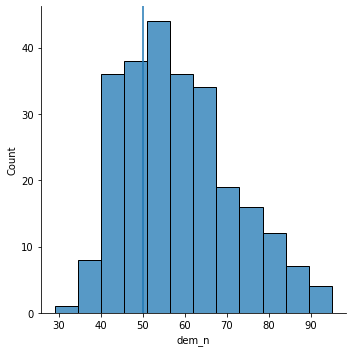

In [118]:
sns.displot(hcr_mid["dem_n"])
plt.axvline(50)

The average D running for re-election recieved almost 60% of the vote, but quite a few lost re-election.

Now let's compare the performance of those who voted for and against the bill. First, let's create separate data frames for the Y and N voters. (Note: we could also keep them together and use the `.loc` function like above when computing means, but it's always good to see multiple ways to do the same thing!)

In [119]:
hcr_mid_yea = hcr_mid[hcr_mid["hcr_yes"] == 1]
hcr_mid_nay = hcr_mid[hcr_mid["hcr_yes"] == 0]

And take the average vote shares among these two groups.

In [120]:
mean_yea = np.mean(hcr_mid_yea["dem_n"])
mean_yea

60.203704833984375

In [121]:
mean_nay = np.mean(hcr_mid_nay["dem_n"])
mean_nay

46.871795654296875

Here is the raw difference of means:

In [122]:
dom = mean_yea - mean_nay
dom

13.3319091796875

**Question 2.1 Use `smf.ols` to run a bivariate regression with `dem_n` as the dependent variable and `hcr_yes` as the independent variable. Save the fitted model as `ols_model`, and then use `.summary()` to get the output. (Hint: see the code between questions 1.1 and 1.2 for an example of what this should look like.) Compare this with the means/difference of means above.**

In [123]:
m1 = smf.ols("dem_n ~ hcr_yes", data=hcr_mid).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dem_n   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     40.99
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           7.39e-10
Time:                        10:41:48   Log-Likelihood:                -993.81
No. Observations:                 255   AIC:                             1992.
Df Residuals:                     253   BIC:                             1999.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.8718      1.917     24.456      0.000      43.097      50.646
hcr_yes       13.3319      2.082      6.402      0.000       9.231      17.433
==============================================================================
Omnibus:                       10.265   Durbin-Watson:                   1.412
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.898
Skew:                           0.498   Prob(JB):                      0.00430
Kurtosis:                       2.817   Cond. No.                         4.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As before, the coefficient on `hcr_yes` is equal to the difference of means.

Now let's think about some reasons why this relationship might not be causal. A major confounding variable is that those who voted Yes likely represent more liberal districts, making their re-election easier. To check this, we will look also bring Obama's 2008 vote share into our analysis.

First, let's look at the relationship between Obama's 2008 vote share and the House members 2010 vote share.

<AxesSubplot:xlabel='obama', ylabel='dem_n'>

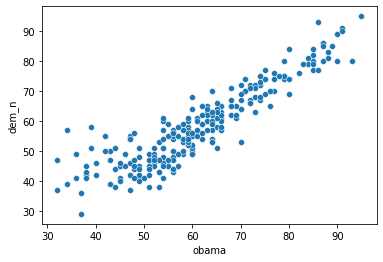

In [124]:
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid)

As we can see, there is a strong positive relationship. This shouldn't surprise us: most people vote for the same party consistently.



Let's look at the relationship between Obama vote share and voting for the ACA.

<AxesSubplot:xlabel='obama', ylabel='hcr_yes'>

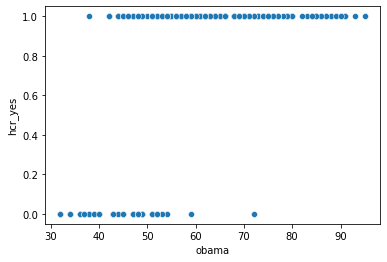

In [125]:
sns.scatterplot(x='obama', y='hcr_yes', data=hcr_mid)

As with some of our simulated data, this looks a little goofy because the hcr_yes variable just takes on value of 0 or 1. We can still run a "linear probability model" with Obama vote share as the independent ($X$) variable and the vote as the dependent ($Y$) variable.

**Question 2.2. Use `smf.ols` to run a linear probability model with Obama vote share as the independent variable and whether the member of congress voted for the ACA as the dependent variable, save the fitted model as `vote_model`, then use the `.summary()` function to see the output. Interpret the slope on the `obama` variable.**

In [126]:
vote_model = smf.ols("hcr_yes ~ obama", data=hcr_mid).fit()
vote_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                hcr_yes   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     98.62
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           7.74e-20
Time:                        10:42:12   Log-Likelihood:                -59.292
No. Observations:                 255   AIC:                             122.6
Df Residuals:                     253   BIC:                             129.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0280      0.090     -0.310      0.757      -0.206       0.150
obama          0.0143      0.001      9.931      0.000       0.011       0.017
==============================================================================
Omnibus:                       39.245   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.175
Skew:                          -1.106   Prob(JB):                     2.84e-12
Kurtosis:                       3.334   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since the DV here is binary, we can interpret the slope as meaning "as Obama vote share goes up by 1%, the probability of voting for the ACA increases by 1.4%.

We can plot this prediction (note: this assumes you saved the `smf.ols` output as `vote_model`!


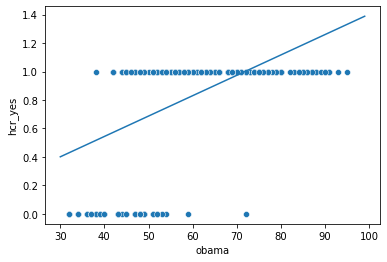

In [127]:
sns.scatterplot(x='obama', y='hcr_yes', data=hcr_mid)
xrange = np.arange(30, 100)
plt.plot(xrange, vote_model.params[0] + xrange*vote_model.params[1])

Now visualize the three variable together, but doing a scatter plot of Obama vote share and 2010 Democratic vote share, with green dots for those who voted Y and orange dots for those who voted N.

<AxesSubplot:xlabel='obama', ylabel='dem_n'>

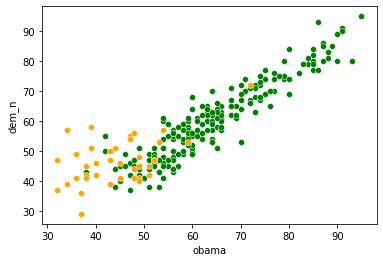

In [128]:
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_y, color="green")
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_n, color="orange")

Note the orange dots are to the left, meaning those who voted N where generally in more moderate/conservative districts.

**Question 2.3. Receate the scatterplot above, and add horizontal lines corresponing to the mean vote share of those who voted No and the mean vote share of those who voted Yes, using the `plt.axhline` function (see the last plot above question 1.2 for an example of this).**

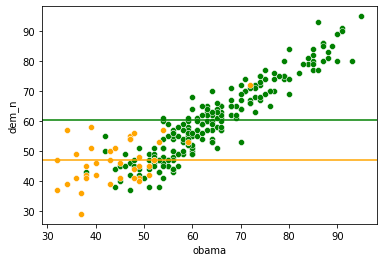

In [129]:
# Code for 2.3
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_y, color="green")
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_n, color="orange")
plt.axhline(mean_yea, color="green")
plt.axhline(mean_nay, color="orange")

And we can look at the relationship between the vote and how liberal the district was by plotting the average Obama vote share among the Y and N districts:

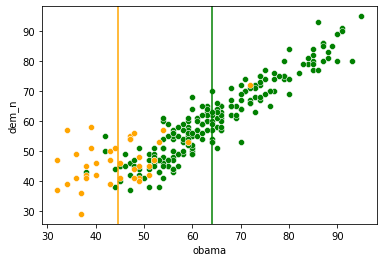

In [130]:
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_y, color="green")
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_n, color="orange")
plt.axvline(np.mean(hcr_mid_y["obama"]), color='green')
plt.axvline(np.mean(hcr_mid_n["obama"]), color='orange')

Combining what we know so far: districts where members voted fr the ACA did much better in the election, but these were also just more liberal ("safe") disticts. 

Now lets use mulitvariate regression to "control" for Obama vote share.

First, let's re-do our bivariate analysis using `smf.ols`.

In [131]:
ols_biv = smf.ols('dem_n ~ hcr_yes', data=hcr_mid).fit()
ols_biv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dem_n   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     40.99
Date:                Mon, 13 Mar 2023   Prob (F-statistic):           7.39e-10
Time:                        10:42:44   Log-Likelihood:                -993.81
No. Observations:                 255   AIC:                             1992.
Df Residuals:                     253   BIC:                             1999.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.8718      1.917     24.456      0.000      43.097      50.646
hcr_yes       13.3319      2.082      6.402      0.000       9.231      17.433
==============================================================================
Omnibus:                       10.265   Durbin-Watson:                   1.412
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.898
Skew:                           0.498   Prob(JB):                      0.00430
Kurtosis:                       2.817   Cond. No.                         4.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Question 2.4. Now run a multivariate regression with both `hcr_yes` and `obama` as independent variables. Save the fitted model as `ols_mv`, and then use `.summary()` to get the output. How does controlling for Obama vote share change the coefficient on the `hcr_yes` variable?**

In [132]:
ols_mv = smf.ols('dem_n ~ hcr_yes + obama', data=hcr_mid).fit()
ols_mv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  dem_n   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     657.5
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          9.98e-101
Time:                        10:42:50   Log-Likelihood:                -779.96
No. Observations:                 255   AIC:                             1566.
Df Residuals:                     252   BIC:                             1577.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4892      1.526      2.943      0.004       1.485       7.494
hcr_yes       -5.3155      1.063     -4.999      0.000      -7.410      -3.221
obama          0.9510      0.029     33.113      0.000       0.894       1.008
==============================================================================
Omnibus:                        9.991   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               12.235
Skew:                           0.331   Prob(JB):                      0.00220
Kurtosis:                       3.844   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Once we control for Obama vote share, the coefficient on `hcr_yes` becomes negative. This means that, holding Obama vote share constant, those who voted for the ACA tended to do *worse* in their reelection bids.

To make a plot, we can pull out the coefficients by adding a `.params` after the name of our fitted model (note: this assumes you named the fitted model `ols_mv`).

In [133]:
ols_mv.params

Intercept    4.489197
hcr_yes     -5.315472
obama        0.951048
dtype: float64

Let's overlay the predicted value for Y and N votes as a function of Obama vote share.

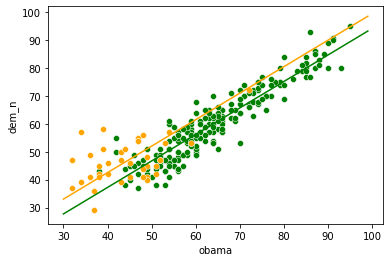

In [134]:
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_y, color="green")
sns.scatterplot(x='obama', y='dem_n', data=hcr_mid_n, color="orange")
xrange = np.arange(30, 100)
plt.plot(xrange, ols_mv.params[0] + xrange*ols_mv.params[2], color="orange")
plt.plot(xrange, ols_mv.params[0] + ols_mv.params[1] + xrange*ols_mv.params[2], color="green")

This is nice illustration of what we mean by "controlling for Obama vote share" or "holding Obama vote share constant". The model accounts for both of these variables, and so the prediction is that *for a fixed level of Obama vote share*, those who vote N do better. Visually, there are two parallel lines, and the N line is always higher. 

Knowing the Obama vote share for each Democrat in the house, the model does not predict that those who vote N will do better in general, because they tend to be in more conservative districts. But it does predict for any two members in districts where Obama got the same vote share, but one votes Y and one votes N, the one voting N will do better.

The takeaway is that the main predictor of how well D's running did in 2010 is how well Obama did in 2008. The fact that those who voted for the ACA did better overall is misleading!

This model predicts that in a counterfactual world where those who voted against the ACA voted for it, they would have done worse in their re-election bids. Conversely, those who voted for the ACA could have done better (and some likely would have been re-elected) if they voted against it. 

Some important caveats:
- This may not be the "right" model: there might be remaining confounding variables.
- We are implicitly assuming that the effect of voting for the ACA is the same for everyone, which is probably not true: in very liberal disticts voters probably would have been unappy in their representative voted no!